# <a id='toc1_'></a>[LendingClub Machine Learning](#toc0_)

This is part 2 of the LendingClub machine learning project. If you haven't read part 1, I recommend reading that first. You can find it in the main folder of this repository with the filename: `Project Part 1.ipynb`.

In this part of the project, we'll focus on loan grade classification.


## <a id='toc1_1_'></a>[What Is Loan Grading?](#toc0_)

Loan grading is defined [here](https://www.investopedia.com/terms/l/loan-grading.asp) as:

Loan grading is a classification system that involves assigning a quality score to a loan based on a borrower's credit history, quality of the collateral, and the likelihood of repayment of the principal and interest. A score can also be applied to a portfolio of loans. Loan grading is part of a lending institution's loan review or credit risk system and is usually an aspect of the credit underwriting and approval processes. 

&nbsp;

**Table of contents**<a id='toc0_'></a>    
- [LendingClub Machine Learning](#toc1_)    
  - [What Is Loan Grading?](#toc1_1_)    
  - [Setup](#toc1_2_)    
    - [Installation and Imports](#toc1_2_1_)    
    - [Initial Setup](#toc1_2_2_)    
  - [Data Loading and First Exploration](#toc1_3_)    
  - [EDA: Exploratory Data Exploration](#toc1_4_)    
    - [Interest Rate](#toc1_4_1_)    
    - [Hardship Amount](#toc1_4_2_)    
    - [Original Projected Additional Accrued Interest](#toc1_4_3_)    
    - [Total Received Interest](#toc1_4_4_)    
    - [Settlement Amount](#toc1_4_5_)    
    - [Balance To Credit Limit](#toc1_4_6_)    
    - [Current Balance vs Credit Limit](#toc1_4_7_)    
    - [Percentage of all bankcard accounts > 75% of limit](#toc1_4_8_)    
    - [Revolving Line Utilization Rate](#toc1_4_9_)    
    - [Total Open To Buy On Revolving Bankcards.](#toc1_4_10_)    
    - [ FICO Range (Low) For The Secondary Applicant](#toc1_4_11_)    
    - [ FICO Range (Low)](#toc1_4_12_)    
    - [Grade](#toc1_4_13_)    
  - [Data Preparation](#toc1_5_)    
  - [Machine Learning](#toc1_6_)    
  - [Summary](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->


---

## <a id='toc1_2_'></a>[Setup](#toc0_)

This section contains the installation of required packages, importing them into the project and initial setup.

### <a id='toc1_2_1_'></a>[Installation and Imports](#toc0_)

In [2]:
%pip install --upgrade pip
%pip install -q -r src/requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import dask.dataframe as dd
import src.lib.functions as f
import pprint
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import optuna
import joblib
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np

### <a id='toc1_2_2_'></a>[Initial Setup](#toc0_)

In [4]:
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 80
logger = f.get_logger()
pp = pprint.PrettyPrinter(indent=4, width=120)
pd.set_option('display.max_columns', None)

&nbsp;

&nbsp;

---

## <a id='toc1_3_'></a>[Data Loading and First Exploration](#toc0_)

In [5]:
run_data_cells = True
if run_data_cells:
    df_accepted = pd.read_csv("src/data/accepted_2007_to_2018Q4.csv", low_memory=False)

Before starting the EDA, let's take a look at which features correlate with the grade and start creating a selection of features to explore during EDA.

In [6]:
if run_data_cells:
    le = LabelEncoder()
    df_accepted.dropna(subset=["grade"], inplace=True)
    df_accepted["grade_le"] = le.fit_transform(df_accepted["grade"])
    corrs = (
        df_accepted.sample(1_000_000).select_dtypes(include=np.number).corr()["grade_le"]
    )
    meaningfull_corrs = corrs.loc[(corrs > 0.25) | (corrs < -0.25)].sort_values(
        ascending=False
    )

    meaningfull_corrs

Let's see how many null values are present in each of these columns.

In [7]:
df_accepted[meaningfull_corrs.index].isna().sum() / df_accepted.shape[0]

grade_le                                      0.000000
int_rate                                      0.000000
hardship_amount                               0.995171
orig_projected_additional_accrued_interest    0.996173
total_rec_int                                 0.000000
all_util                                      0.383227
settlement_amount                             0.984851
bc_util                                       0.033650
percent_bc_gt_75                              0.033344
revol_util                                    0.000797
sec_app_revol_util                            0.953030
last_fico_range_low                           0.000000
bc_open_to_buy                                0.033147
sec_app_fico_range_high                       0.952217
sec_app_fico_range_low                        0.952217
last_fico_range_high                          0.000000
fico_range_high                               0.000000
fico_range_low                                0.000000
dtype: flo

There's quite a few features with a lot of NaN values, hardship amount for instance has more than 99.5% of NaN values, but has a very strong correlation with the grade of the loan. This is because this feature is NaN if the borrower has no hardship reported and is paying the loan as is expected. Since I'm planning on using XGBoost models, this is not an issue. It might even be valuable, especially when null values hold important information like some of the features above.

## <a id='toc1_4_'></a>[EDA: Exploratory Data Exploration](#toc0_)

Let's explore the features we identified above.

In [8]:
if run_data_cells:
    df_part_2 = df_accepted[meaningfull_corrs.index].copy()
    df_part_2["grade"] = df_accepted["grade"].copy()
    df_part_2.drop(
        [
            "grade_le",
            "last_fico_range_low",
            "last_fico_range_high",
            "sec_app_fico_range_high",
            "fico_range_high",
        ],
        axis=1,
        inplace=True,
    )
    df_part_2.to_parquet("src/data/df_part_2.parquet")
else:
    df_part_2 = pd.read_parquet("src/data/df_part_2.parquet")

&nbsp;

### <a id='toc1_4_1_'></a>[Interest Rate](#toc0_)

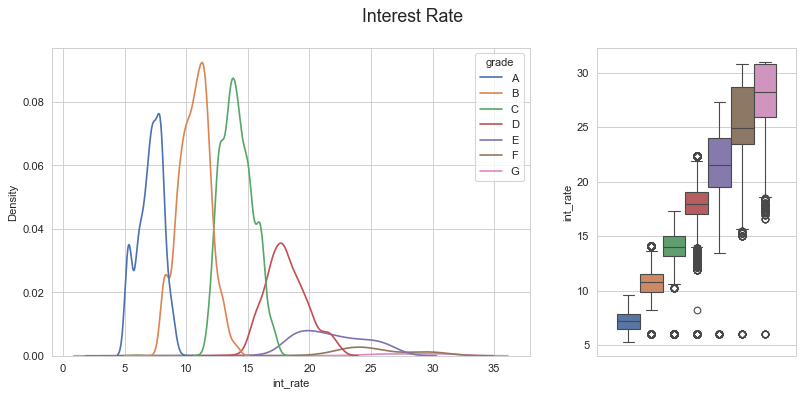

In [9]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "int_rate",
    title="Interest Rate",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

We can see that as grades get worse, the interest rate rises with it.

&nbsp;

### <a id='toc1_4_2_'></a>[Hardship Amount](#toc0_)

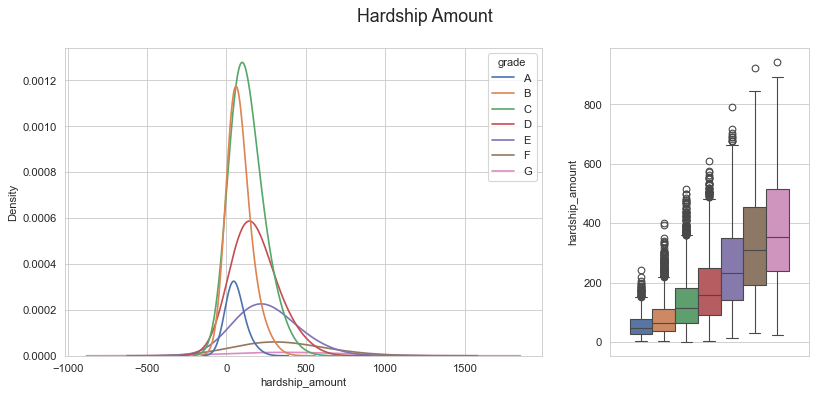

In [10]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "hardship_amount",
    title="Hardship Amount",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

Here, we can see something similar as with the interest rate, only in smaller increases. The hardship amount rises as the grade of the loan get's worse.

&nbsp;

### <a id='toc1_4_3_'></a>[Original Projected Additional Accrued Interest](#toc0_)

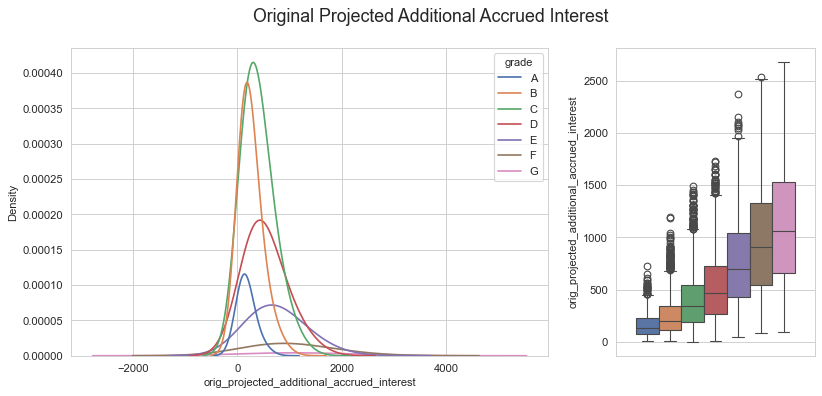

In [11]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "orig_projected_additional_accrued_interest",
    title="Original Projected Additional Accrued Interest",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

Again, we can see an increase when grades go down, however, this is self explanatory. We already saw that the interest rate goes up as grades go down, that then of course causes the projected interest to be larger.

&nbsp;

### <a id='toc1_4_4_'></a>[Total Received Interest](#toc0_)

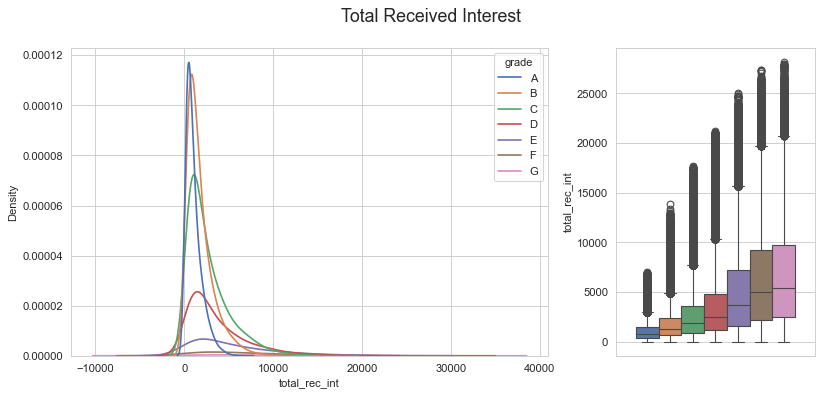

In [12]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "total_rec_int",
    title="Total Received Interest",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

The situation here is the same as the projected accrued interest. This is again explained by the interest rate being higher.

&nbsp;

### <a id='toc1_4_5_'></a>[Settlement Amount](#toc0_)

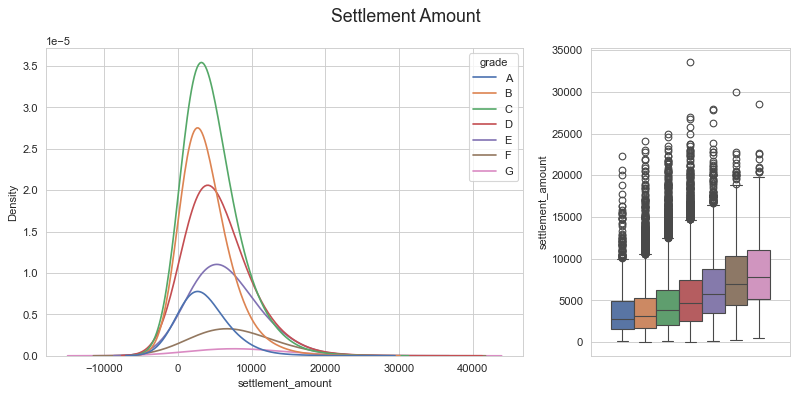

In [13]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "settlement_amount",
    title="Settlement Amount",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

Settlement amount also goes up as loan grades drop.

&nbsp;

### <a id='toc1_4_6_'></a>[Balance To Credit Limit](#toc0_)

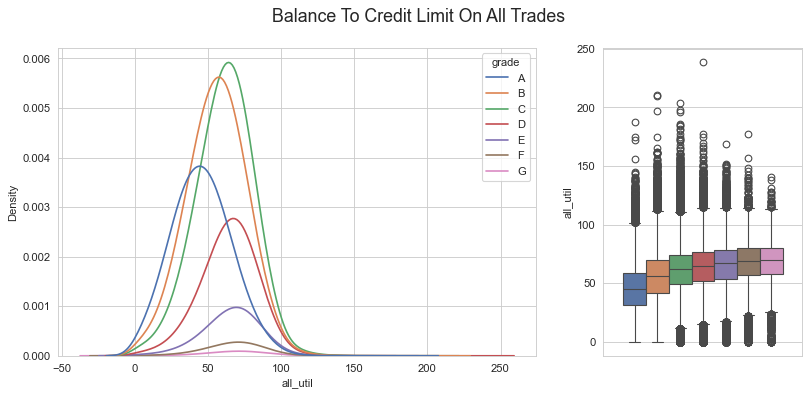

In [14]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "all_util",
    title="Balance To Credit Limit On All Trades",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

Balance to credit limit also rises, but stabilizes as the grade lowers.

&nbsp;

### <a id='toc1_4_7_'></a>[Current Balance vs Credit Limit](#toc0_)
Ratio of total current balance to high credit/credit limit for all bankcard accounts.

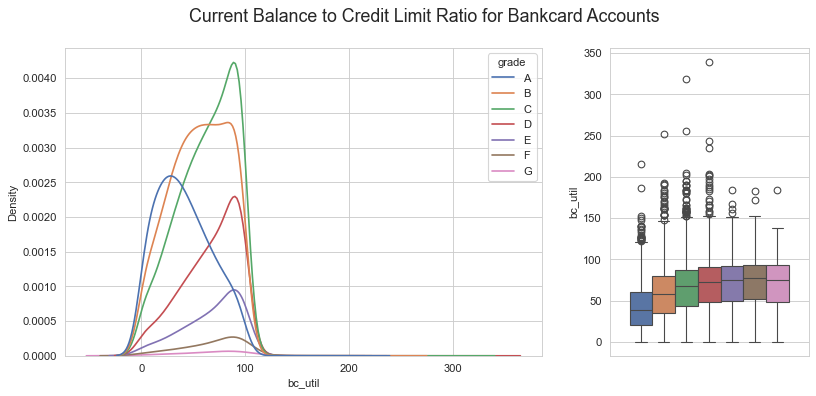

In [15]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "bc_util",
    title="Current Balance to Credit Limit Ratio for Bankcard Accounts",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

This ratio also rises as grades lower, but stabilizes on the lower grades.

&nbsp;

### <a id='toc1_4_8_'></a>[Percentage of all bankcard accounts > 75% of limit](#toc0_)

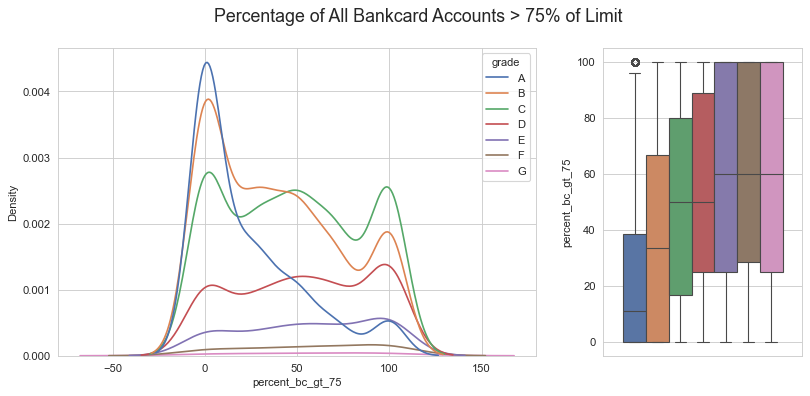

In [16]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "percent_bc_gt_75",
    title="Percentage of All Bankcard Accounts > 75% of Limit",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

Here again, the ratio increases as grades go down.

&nbsp;

### <a id='toc1_4_9_'></a>[Revolving Line Utilization Rate](#toc0_)

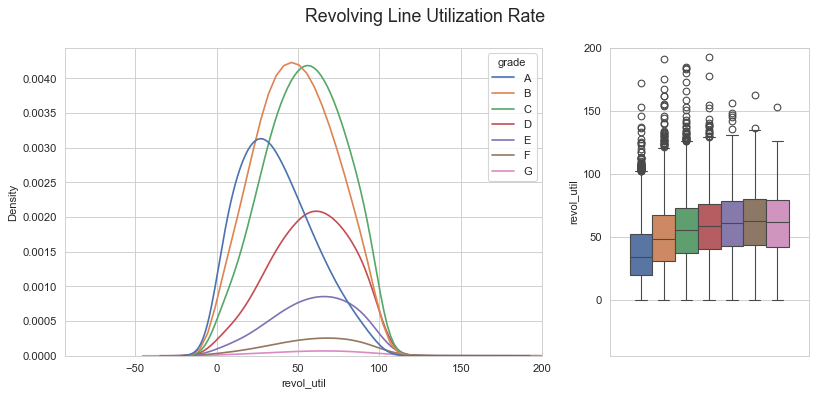

In [17]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "revol_util",
    title="Revolving Line Utilization Rate",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
ax = plt.gcf().get_axes()
ax[1].get_legend().remove()
ax[0].set_xlim(ax[0].get_xlim()[0], 200)
ax[1].set_ylim(ax[1].get_ylim()[0], 200);

Lower grades also have a larger revolving line utilization rate, they do seem to stabilize in the lower grades.

&nbsp;

### <a id='toc1_4_10_'></a>[Total Open To Buy On Revolving Bankcards.](#toc0_)

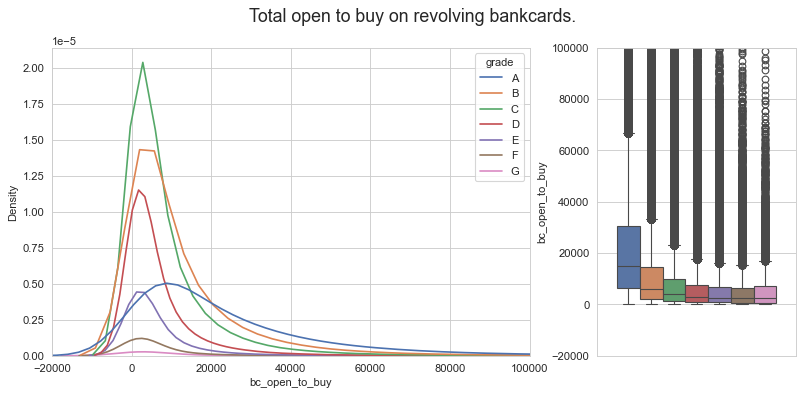

In [18]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "bc_open_to_buy",
    title="Total open to buy on revolving bankcards.",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
ax = plt.gcf().get_axes()
ax[1].get_legend().remove()
ax[0].set_xlim(-20_000, 100_000)
ax[1].set_ylim(-20_000, 100_000);

Lower loan grade applicants tend to have less open to buy balance on their bankcards. This also stabilizes for the lower grades.

&nbsp;

### <a id='toc1_4_11_'></a>[ FICO Range (Low) For The Secondary Applicant](#toc0_)

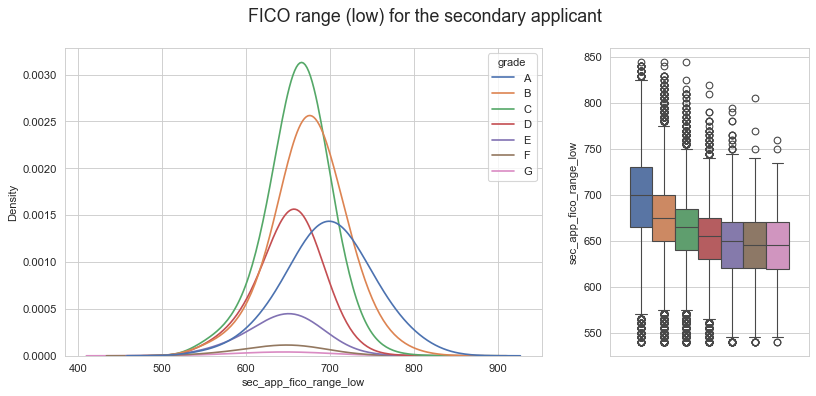

In [19]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "sec_app_fico_range_low",
    title="FICO range (low) for the secondary applicant",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

In cases where there was a second applicant, their FICO range (credit score) drops as the loan grade drops.

&nbsp;

### <a id='toc1_4_12_'></a>[ FICO Range (Low)](#toc0_)

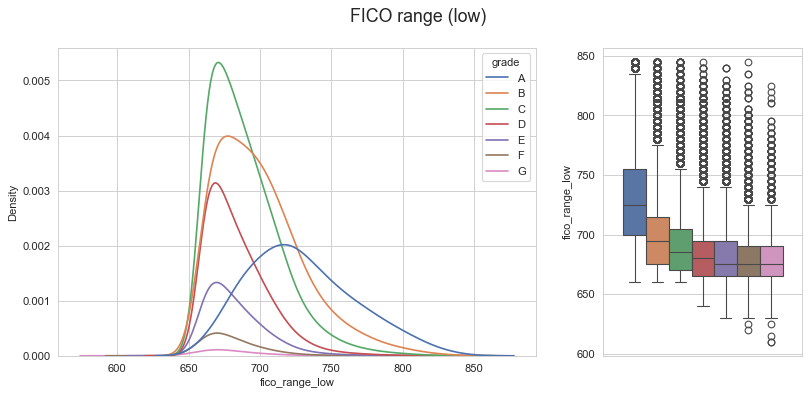

In [20]:
f.plot_kde_and_box(
    df_part_2.sort_values("grade"),
    "fico_range_low",
    title="FICO range (low)",
    hue="grade",
    palette="deep",
    bw_adjust=4,
    figsize=(12, 5),
)
plt.gcf().get_axes()[1].get_legend().remove()

The same pattern is visible for the FICO range of the main applicant, dropping lower as the grade of the loan drops.

&nbsp;

### <a id='toc1_4_13_'></a>[Grade](#toc0_)

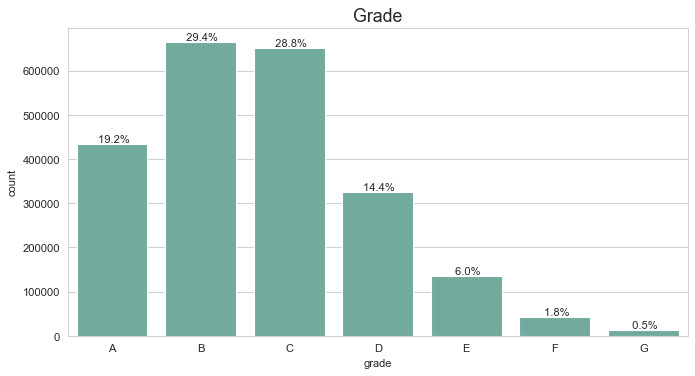

In [21]:
f.countplot(df_part_2.sort_values(by="grade"), "grade", title="Grade", bar_labels=True, figsize=(12, 5));

The majority of loans is grade B and C, with A and D as the runner-ups. The really low grades of F and G are very uncommon.

## <a id='toc1_5_'></a>[Data Preparation](#toc0_)

Let's prepare the data before training any models. This is again implemented in the `functions.py` file, with a short description here:

The function takes all meaningfull correlation columns except for `last_fico_range_low, last_fico_range_high, sec_app_fico_range_high` and `fico_range_high`. This is because the last known FICO range is not meaningful when we're predicting grade at the time of loan application, and I've decided to use the low end of the FICO range as this represents the worst case scenario. Finally, the rows were `grade` is NaN are also dropped, and other NaN values are filled in with -1.

In [22]:
df = f.part_2_preprocess(df_accepted[meaningfull_corrs.index])
df.head(1)

,grade_le,int_rate,hardship_amount,orig_projected_additional_accrued_interest,total_rec_int,all_util,settlement_amount,bc_util,percent_bc_gt_75,revol_util,sec_app_revol_util,bc_open_to_buy,sec_app_fico_range_low,fico_range_low
0,2,13.99,-1.0,-1.0,821.72,34.0,-1.0,37.2,0.0,29.7,-1.0,1506.0,-1.0,675.0


Let's split the data into a training, validation and testing set.

In [23]:
ml_data = f.train_test_valid_split(
    data=df.drop(columns="int_rate"), label_column="grade_le", stratify="grade_le", test_size=0.2, valid_size=0.2
)

## <a id='toc1_6_'></a>[Machine Learning](#toc0_)

Let's start of by finding the optimal hyperparameters and training the model with them.

In [24]:
p2_xgb_model_path = "src/models/p2_best_xgb_model.joblib"

if not os.path.exists(p2_xgb_model_path):
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: f.xgb_classification_objective(
            trial=trial,
            x_train=ml_data["x_train"],
            y_train=ml_data["y_train"],
            x_valid=ml_data["x_valid"],
            y_valid=ml_data["y_valid"],
        ),
        n_trials=50,
    )

    best_xgb_model = f.get_pipeline(
        XGBClassifier(**study.best_params),
        numerical_columns=ml_data["x_train"].select_dtypes(include=np.number).columns,
    ).fit(ml_data["x_train"], ml_data["y_train"])

    joblib.dump(best_xgb_model, p2_xgb_model_path)
else:
    best_xgb_model = joblib.load(p2_xgb_model_path)

In [25]:
f.test_model(
    pred_train=best_xgb_model.predict(ml_data["x_train"]),
    pred_test=best_xgb_model.predict(ml_data["x_valid"]),
    y_train=ml_data["y_train"],
    y_test=ml_data["y_valid"],
    logger=logger,
)

2024-02-05 09:42:23,106 - root - INFO - Training scores:

2024-02-05 09:42:23,107 - root - INFO -     - Accuracy: 0.480
2024-02-05 09:42:23,107 - root - INFO -     - Precision: 0.479
2024-02-05 09:42:23,108 - root - INFO -     - Recall: 0.480
2024-02-05 09:42:23,276 - root - INFO - Test scores:

2024-02-05 09:42:23,277 - root - INFO -     - Accuracy: 0.481
2024-02-05 09:42:23,277 - root - INFO -     - Precision: 0.480
2024-02-05 09:42:23,277 - root - INFO -     - Recall: 0.481


Those values don't look that good, let's take a look at the ROC curve.

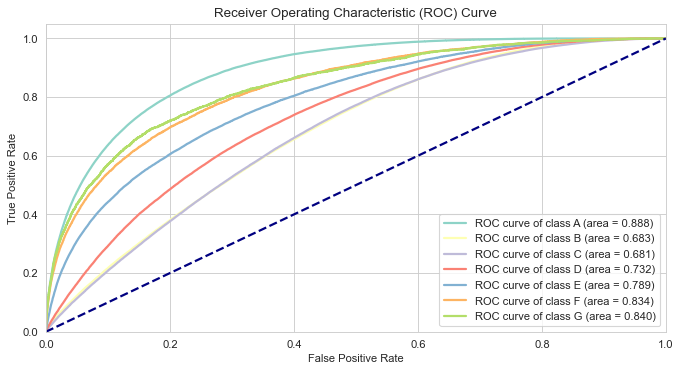

In [26]:
f.plot_multiclass_roc(
    best_xgb_model,
    ml_data["x_test"],
    ml_data["y_test"],
    n_classes=7,
    class_labels=le.classes_,
)

There's quite a large difference between different classes. The best and worst grades are being predicted best by the model, while the middle grades seem more difficult.

Let's take a look at the SHAP values.

Plotting SHAP values for class 1


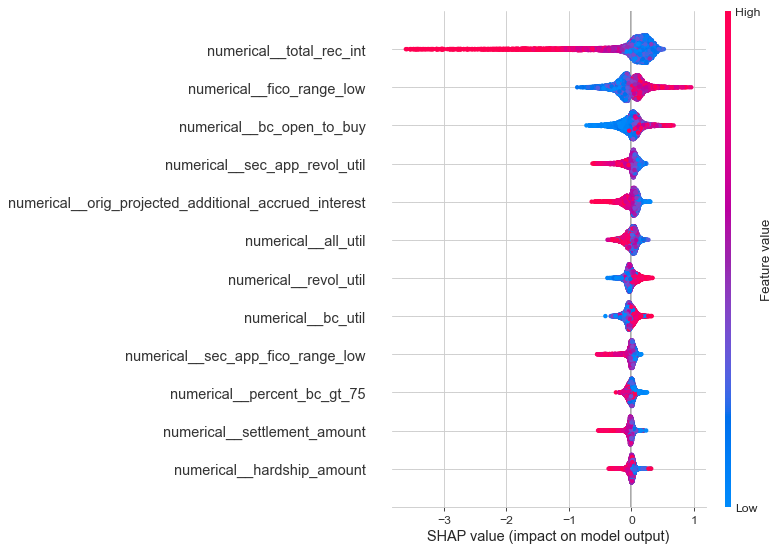

Plotting SHAP values for class 7


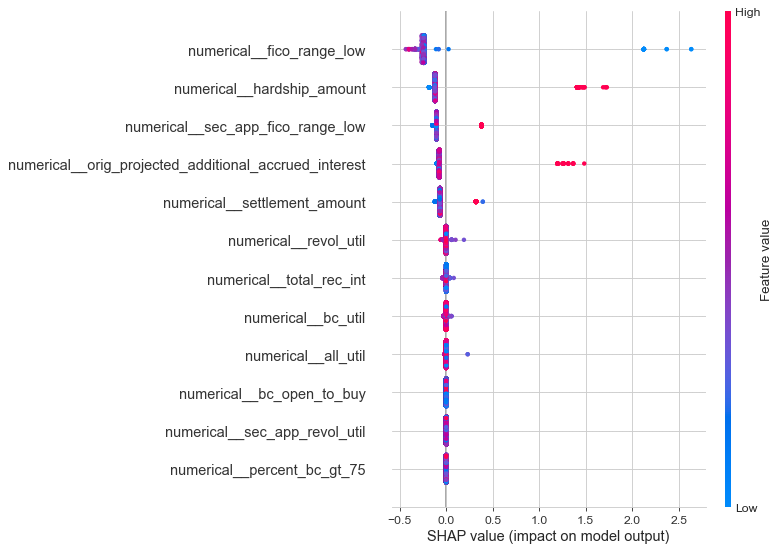

In [27]:
f.plot_xgb_shap(
    best_xgb_model.named_steps["model"],
    best_xgb_model.named_steps["preprocessor"].transform(ml_data["x_train"].sample(10_000)),
    feature_names = best_xgb_model.named_steps["preprocessor"].get_feature_names_out(),
    figsize=(10, 7),
    multi_class=True,
    classes_to_plot=[1,7],
)

Here, we can see a big difference in shap values between the best and worst loan grades.

&nbsp;

&nbsp;

---

## <a id='toc1_7_'></a>[Summary](#toc0_)

This has been part 2 of the project. Before we move on to part 3, I'd like to provide a brief summary of what was done and found.

For this part, we used the highest correlating features to predict the grade of the loan except the interest rate. Since that will be predicted in part 3, I worked under the assumption that it is undetermined yet when predicting the grade. If subject matter experts should declare that the interest rate can be used for this, the model improves significantly from what I've seen in experimenting.

The correlations we saw were also clear in the EDA. Each feature had a clear connection with the variable of interest.

The data was then prepared and an XGBoost model was trained and evaluated, where a significant difference in performance could be seen between the different classes.

Let's move on to the final part of the project. You can find this part in the notebook named **Project Part 3.ipynb**.

